In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. CARGA DE DATOS Y LIMPIEZA

In [119]:
df = pd.read_csv('/home/ubuntu/STG-fractura_cadera/2026/data_preprocessed/data_preprocessed_2018-2026/DATOS_PREPROCESADOS.csv')

# Columnas a excluir (Data Leakage + Target)
excluded_cols = ['ds_estancia', 'ds_pre_oper', 'ds_post_oper', 'gsitalta', 'gsitalta_agrupada']

X = df.drop(columns=[c for c in excluded_cols if c in df.columns])
y = df['ds_post_oper']   # Variable objetivo

print(f"Datos cargados. Pacientes: {X.shape[0]}, Variables predictoras: {X.shape[1]}")

Datos cargados. Pacientes: 854, Variables predictoras: 58


# 2. PREPROCESADO

In [120]:
# Dividir en conjunto de Entrenamiento (80%) y Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. ENTRENAMIENTO (ELASTIC NET)

In [121]:
# Usamos los hiperparámetros que mejor funcionaron en las pruebas
model = ElasticNet(
    alpha=0.7, 
    l1_ratio=0.1, 
    selection='random', 
    max_iter=10000, 
    random_state=42
)

print("Entrenando modelo...")
model.fit(X_train_scaled, y_train)

# GUARDAR MODELO Y SCALER
joblib.dump(model, 'modelo_elasticnet.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'columnas_modelo.pkl')
print("✓ Modelo, scaler y columnas guardados")

Entrenando modelo...
✓ Modelo, scaler y columnas guardados


# 4. EVALUACIÓN

In [122]:
# Predecir en datos nuevos (Test)
y_pred = model.predict(X_test_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- RESULTADOS DEL MODELO ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} días")
print(f"(El modelo se equivoca, en promedio, por {mae:.2f} días)")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.3f}")


--- RESULTADOS DEL MODELO ---
Error Medio Absoluto (MAE): 3.28 días
(El modelo se equivoca, en promedio, por 3.28 días)
Raíz del Error Cuadrático Medio (RMSE): 5.22
R2 Score: 0.148


# 5. VISUALIZACIÓN

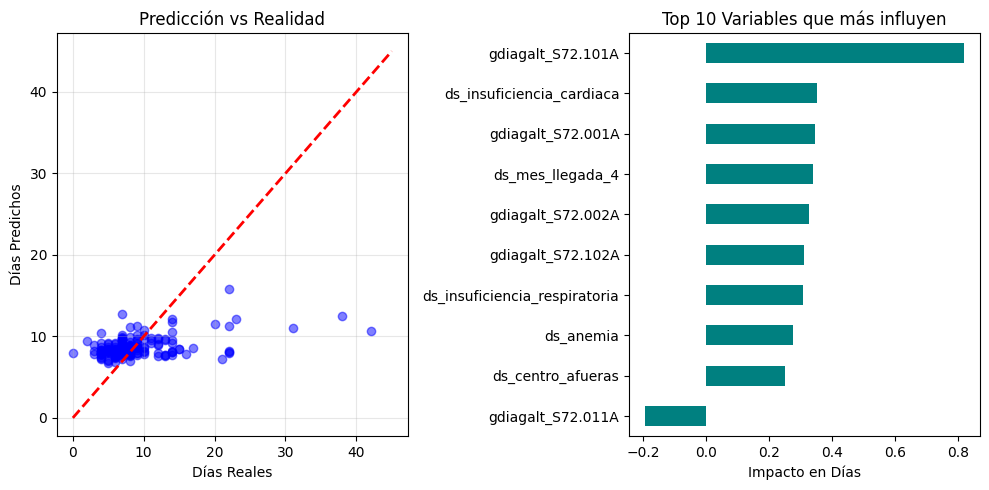

In [123]:
plt.figure(figsize=(10, 5))

# Gráfico 1: Predicción vs Realidad
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
# Línea de perfección
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Días Reales')
plt.ylabel('Días Predichos')
plt.title('Predicción vs Realidad')
plt.grid(True, alpha=0.3)

# Gráfico 2: Importancia de Variables (Coeficientes)
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X.columns)
# Mostrar solo las 10 más importantes
top_coefs = coefs.abs().sort_values(ascending=False).head(10)
coefs[top_coefs.index].sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Variables que más influyen')
plt.xlabel('Impacto en Días')

plt.tight_layout()
plt.show()

# 6. EJEMPLO DE PREDICCIÓN

In [124]:
# Tomamos un paciente al azar del test para ver qué predice
sample_idx = 0
real_val = y_test.iloc[sample_idx]
pred_val = y_pred[sample_idx]

print(f"\nEjemplo Paciente #{sample_idx}:")
print(f"Estancia Real: {real_val} días")
print(f"Estancia Predicha: {pred_val:.1f} días")
print(f"Diferencia: {abs(real_val - pred_val):.1f} días")


Ejemplo Paciente #0:
Estancia Real: 9 días
Estancia Predicha: 8.5 días
Diferencia: 0.5 días


## Para PRO


In [125]:
# Codigo para hacer predicciones con el modelo guardado
# Cargar al inicio (solo una vez)
model = joblib.load('modelo_elasticnet.pkl')
scaler = joblib.load('scaler.pkl')
columnas = joblib.load('columnas_modelo.pkl')

def predecir_estancia(datos_paciente):
    """
    datos_paciente: DataFrame con datos del paciente
    """
    # Validar columnas
    assert list(datos_paciente.columns) == columnas, "Columnas no coinciden"
    
    # Escalar y predecir
    datos_scaled = scaler.transform(datos_paciente)
    prediccion = model.predict(datos_scaled)
    return round(prediccion[0], 1)

In [126]:
import pandas as pd

# Crear DataFrame con UN paciente nuevo (mismas columnas que en entrenamiento)
nuevo_paciente = pd.DataFrame({
    'edad': [65],
    'sexo': [1],
    'asa': [2],
    'cirugia_urgente': [0],
    # ... todas las demás columnas que usaste en X
    # IMPORTANTE: Deben estar en el MISMO ORDEN que columnas_modelo.pkl
})

# Predecir
dias_estimados = predecir_estancia(nuevo_paciente)
print(f"Estancia estimada: {dias_estimados} días")

AssertionError: Columnas no coinciden